In [ ]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image

from socket import timeout

from google.colab import files

!pip3 install -q torch torchvision
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler, Sampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Download train data
!wget "https://storage.googleapis.com/dlcourse_ai/train.zip"
!unzip -q "train.zip"

train_folder = "train_kaggle/"
# Count number of files in the train folder, should be 4603
print('Number of files in the train folder', len(os.listdir(train_folder)))

# Download test data
!wget "https://storage.googleapis.com/dlcourse_ai/test.zip"
!unzip -q "test.zip"

test_folder = "test_kaggle/"
# Count number of files in the test folder, should be 1150
print('Number of files in the test folder', len(os.listdir(test_folder)))

--2022-12-16 13:51:23--  https://storage.googleapis.com/dlcourse_ai/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 562348083 (536M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 536.30M   132MB/s    in 4.2s    

2022-12-16 13:51:27 (128 MB/s) - ‘train.zip’ saved [562348083/562348083]

Number of files in the train folder 4603
--2022-12-16 13:51:37--  https://storage.googleapis.com/dlcourse_ai/test.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 140788786 (134M) [application/zip]
Saving to: ‘test.zip’

test

In [ ]:
device = torch.device("cuda:0")

In [ ]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.folder = folder
        self.filenames = os.listdir(folder)

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, index):        
        # TODO Implement getting item by index
        # Hint: os.path.join is helpful!
        y = 0
        img_id = self.filenames[index]
        img = Image.open(os.path.join(self.folder, img_id))
        if self.transform:
            img = self.transform(img)
        if img_id.startswith("frankfurter") or img_id.startswith("chili-dog") or img_id.startswith("hotdog"):
            y = 1
        return img, y, img_id

In [ ]:
# First, lets load the dataset
train_dataset = HotdogOrNotDataset("train_kaggle",
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [ ]:
batch_size = 64

data_size = len(train_dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler = None):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        if scheduler is not None:
            scheduler.step()
        model.train() # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y, _) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y_gpu.shape[0]

            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        print("epoch %d Average loss: %f, Train accuracy: %f, val accuracy: %f" %
                  (epoch+1, ave_loss, train_accuracy, val_accuracy))
        #if train_accuracy < 0.15:
        #    return loss_history, train_history, val_history

    return loss_history, train_history, val_history

def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader

    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y, _) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y_gpu.shape[0]

    train_accuracy = float(correct_samples) / total_samples
    return train_accuracy

In [ ]:
def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')

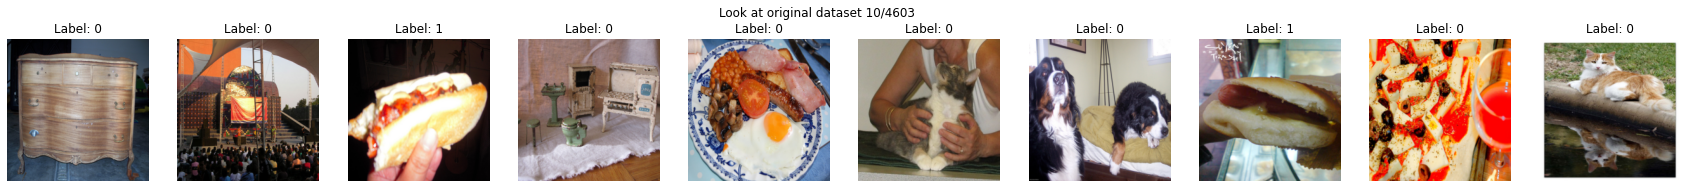

In [ ]:
dataset = HotdogOrNotDataset("train_kaggle", transform=transforms.Compose([transforms.Resize((224, 224))]))
np.random.shuffle(indices)
visualize_samples(dataset, indices, "Look at original dataset")

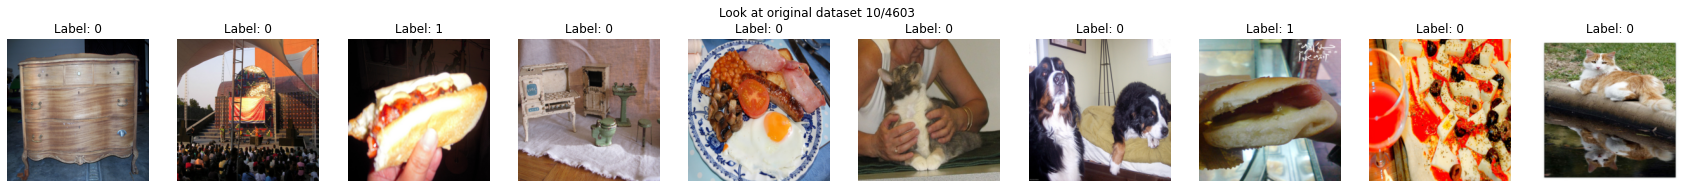

In [ ]:
dataset = HotdogOrNotDataset("train_kaggle", transform=transforms.Compose([transforms.Resize((224, 224)),
transforms.RandomAutocontrast(),
transforms.RandomHorizontalFlip()
]))

visualize_samples(dataset, indices, "Look at original dataset")

In [ ]:
import torch.nn as nn
import torch.optim as optim

train_dataset = HotdogOrNotDataset("train_kaggle",
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)


model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)
parameters = model.parameters()

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters, lr=0.001, momentum=0.9)

loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

epoch 1 Average loss: 0.291407, Train accuracy: 0.869400, val accuracy: 0.938043
epoch 2 Average loss: 0.132688, Train accuracy: 0.954113, val accuracy: 0.947826
epoch 3 Average loss: 0.099551, Train accuracy: 0.970133, val accuracy: 0.951087
epoch 4 Average loss: 0.074011, Train accuracy: 0.978550, val accuracy: 0.950000
epoch 5 Average loss: 0.052592, Train accuracy: 0.986967, val accuracy: 0.954348


In [ ]:
import torch.nn as nn
import torch.optim as optim

train_dataset = HotdogOrNotDataset("train_kaggle",
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
                          transforms.RandomHorizontalFlip(),
                          transforms.RandomAutocontrast()                       
                       ])
                      )

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)


model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)
parameters = model.parameters()

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters, lr=0.001, momentum=0.9)

loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

epoch 1 Average loss: 0.355754, Train accuracy: 0.831387, val accuracy: 0.929348
epoch 2 Average loss: 0.170932, Train accuracy: 0.936193, val accuracy: 0.945652
epoch 3 Average loss: 0.126532, Train accuracy: 0.954385, val accuracy: 0.944565
epoch 4 Average loss: 0.109058, Train accuracy: 0.960901, val accuracy: 0.952174
epoch 5 Average loss: 0.086548, Train accuracy: 0.969590, val accuracy: 0.951087
